In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import yaml


with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

def read(config_str):
    return pd.read_csv(resolve_path(config[config_str]))

def geo_read(config_str):
    return gpd.read_file(resolve_path(config[config_str]))

Matplotlib is building the font cache; this may take a moment.


In [2]:
CPIS2000 = geo_read('Africa_CPIS_2000_shp_path')
CPIS2021 = geo_read('Africa_CPIS_2021_shp_path')

# Reproject onto a common projected CRS (uses meters as units)
CPIS2000 = CPIS2000.to_crs(epsg=3395)
CPIS2021 = CPIS2021.to_crs(epsg=3395)

# Find the area covered by CPIS in each country in meters squared and in hectares
CPIS2000['Area_m2'] = CPIS2000.geometry.area
CPIS2021['Area_m2'] = CPIS2021.geometry.area

# Convert m^2 to 1000ha
CPIS2000['Area_1000ha'] = CPIS2000['Area_m2'] / 10000000
CPIS2021['Area_1000ha'] = CPIS2021['Area_m2'] / 10000000

# Drop the geometry and save the area data as a CSV
cPIS2000 = CPIS2000.drop(columns='geometry')
cPIS2021 = CPIS2021.drop(columns='geometry')

# Add year column
cPIS2000['Year'] = 2000
cPIS2021['Year'] = 2021

# Save
output_dir2000 = resolve_path(config['Africa_CPIS_2000_Areas_path'])
output_dir2021 = resolve_path(config['Africa_CPIS_2021_Areas_path'])

cPIS2000.to_csv(output_dir2000, index=False)
cPIS2021.to_csv(output_dir2021, index=False)

# Merge the files and save
CPIS = pd.concat([cPIS2000, cPIS2021])
CPIS.to_csv(resolve_path(config['Africa_CPIS_Areas_path']))

In [3]:
AQUA2000 = read('AQUA_AfricaIrrigation_2000')
AQUA2021 = read('AQUA_AfricaIrrigation_2021')
AQUA = read('AQUA_AfricaIrrigation')

# Compute total area of Irrigation
total_area_2000_AQUA = AQUA2000['Value'].sum()
total_area_2021_AQUA = AQUA2021['Value'].sum()

# Compute the total area of CPIS
total_area_2000_CPIS = CPIS2000['Area_1000ha'].sum()
total_area_2021_CPIS = CPIS2021['Area_1000ha'].sum()

print(f'Total CPIS (area in 1000ha) in 2000: {total_area_2000_CPIS:.2f}')
print(f'Total CPIS (area in 1000ha) in 2021: {total_area_2021_CPIS:.2f}')

# Compute % of total Irrigation that was CPIS in 2000 and 2020
ratio_2000 = 100 * total_area_2000_CPIS/total_area_2000_AQUA
ratio_2021 = 100 * total_area_2021_CPIS/total_area_2021_AQUA

# Compute the percent increase in all irrigation and in CPIS
percent_increase_AQUA = 100 * (total_area_2021_AQUA - total_area_2000_AQUA) / total_area_2000_AQUA
percent_increase_CPIS = 100 * (total_area_2021_CPIS - total_area_2000_CPIS) / total_area_2000_CPIS

print(f'The area equipped for irrigation increased by {percent_increase_AQUA:.2f}% between 2000 and 2021.')
print(f'The area covered by CPIS increased by {percent_increase_CPIS:.2f}% between 2000 and 2021')

print(f'In 2000, center pivot irrigation systems made up {ratio_2000:.2f}% of the total area equipped with irrigation.')
print(f'In 2021, center pivot irrigation systems made up {ratio_2021:.2f}% of the total area equipped with irrigation.')



Total CPIS (area in 1000ha) in 2000: 389.43
Total CPIS (area in 1000ha) in 2021: 969.19
The area equipped for irrigation increased by 51.81% between 2000 and 2021.
The area covered by CPIS increased by 148.87% between 2000 and 2021
In 2000, center pivot irrigation systems made up 3.62% of the total area equipped with irrigation.
In 2021, center pivot irrigation systems made up 5.94% of the total area equipped with irrigation.


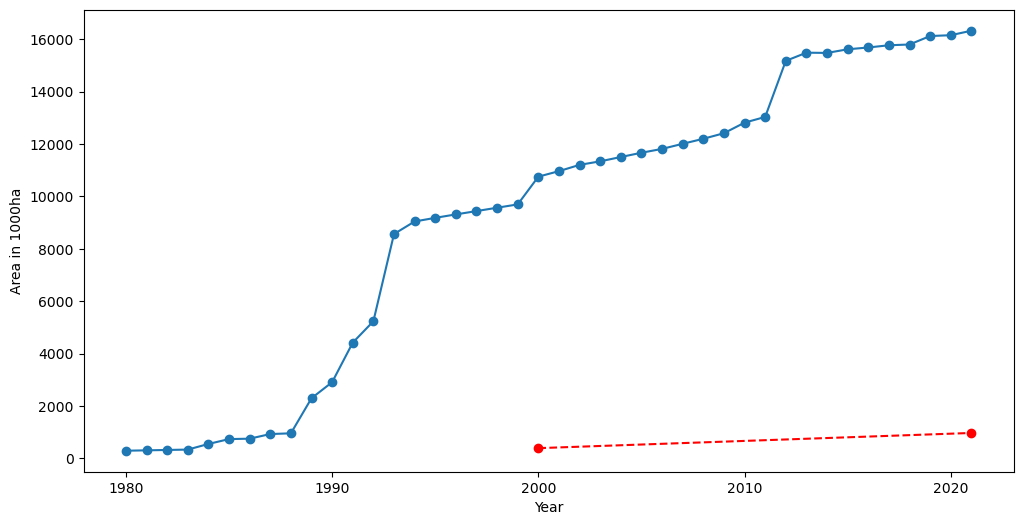

In [4]:
# Sum values in each year
AQUA_yearly = AQUA.groupby('Year')['Value'].sum().reset_index()

CPIS_sum = CPIS.groupby('Year')['Area_1000ha'].sum().reset_index()

plt.figure(figsize = (12,6))
plt.plot(AQUA_yearly['Year'], AQUA_yearly['Value'], label = 'Total Area Equipped for Irrigation', marker = 'o')

plt.scatter(CPIS_sum['Year'], CPIS_sum['Area_1000ha'], color = 'red', label = 'Total Area Covered By Center Pivot Irrigation Systems')

plt.plot(CPIS_sum['Year'], CPIS_sum['Area_1000ha'], 'r--')

plt.xlabel('Year')
plt.ylabel('Area in 1000ha')
plt.show()

Same thing but only for countries in Sub-Saharan Africa

In [17]:
# Filter all datasets to remove countries in northern Africa
northern_africa_countries = ['Algeria', 'Egypt', 'Libya', 'Morocco', 'Sudan', 'Tunisia', 'Western Sahara']
AQUA2000 = AQUA2000[~AQUA2000['Area'].isin(northern_africa_countries)]
AQUA2021 = AQUA2021[~AQUA2021['Area'].isin(northern_africa_countries)]
CPIS2000 = CPIS2000[~CPIS2000['Country'].isin(northern_africa_countries)]
print(CPIS2021.shape)
CPIS2021 = CPIS2021[~CPIS2021['Country'].isin(northern_africa_countries)]
print(CPIS2021.shape)

(29146, 6)
(27439, 6)


In [22]:
# Compute total area of Irrigation
total_area_2000_AQUA = AQUA2000['Value'].sum()
total_area_2021_AQUA = AQUA2021['Value'].sum()

# Compute the total area of CPIS
total_area_2000_CPIS = CPIS2000['Area_1000ha'].sum()
total_area_2021_CPIS = CPIS2021['Area_1000ha'].sum()

print(f'Total CPIS (area in 1000ha) in 2000: {total_area_2000_CPIS:.2f} in SSA')
print(f'Total CPIS (area in 1000ha) in 2021: {total_area_2021_CPIS:.2f} in SSA')

# Compute % of total Irrigation that was CPIS in 2000 and 2020
ratio_2000 = 100 * total_area_2000_CPIS/total_area_2000_AQUA
ratio_2021 = 100 * total_area_2021_CPIS/total_area_2021_AQUA

# Compute the percent increase in all irrigation and in CPIS
percent_increase_AQUA = 100 * (total_area_2021_AQUA - total_area_2000_AQUA) / total_area_2000_AQUA
percent_increase_CPIS = 100 * (total_area_2021_CPIS - total_area_2000_CPIS) / total_area_2000_CPIS

print(f'The area equipped for irrigation increased by {percent_increase_AQUA:.2f}% between 2000 and 2021 in SSA.')
print(f'The area covered by CPIS increased by {percent_increase_CPIS:.2f}% between 2000 and 2021 in SSA')

print(f'In 2000, center pivot irrigation systems made up {ratio_2000:.2f}% of the total area equipped with irrigation in SSA.')
print(f'In 2021, center pivot irrigation systems made up {ratio_2021:.2f}% of the total area equipped with irrigation in SSA.')

# print how many times faster CPIS expanded
times_faster_expansion = percent_increase_CPIS / percent_increase_AQUA
print(f'CPIS expanded {times_faster_expansion:.2f} times faster than other forms of irrigation in Sub-Saharan Africa between 2000 and 2021.')

Total CPIS (area in 1000ha) in 2000: 306.58 in SSA
Total CPIS (area in 1000ha) in 2021: 892.62 in SSA
The area equipped for irrigation increased by 53.98% between 2000 and 2021 in SSA.
The area covered by CPIS increased by 191.15% between 2000 and 2021 in SSA
In 2000, center pivot irrigation systems made up 6.82% of the total area equipped with irrigation in SSA.
In 2021, center pivot irrigation systems made up 12.89% of the total area equipped with irrigation in SSA.
CPIS expanded 3.54 times faster than other forms of irrigation in Sub-Saharan Africa between 2000 and 2021.
